In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import progressbar
import multiprocessing as mp

# Create fake data

$h(x)=\text{sign}(w^0_1\tanh(w^1_ix^i)+w^0_2\tanh(w^2_ix^i))$

In [2]:
data=np.random.normal(0.1,3,(1000000,10))

In [3]:
w1=np.random.normal(1,5,10)
w2=np.random.normal(-1,10,10)
w0=np.random.normal(3,20,2)

In [4]:
y=w0[0]*np.tanh(data.dot(w1))+w0[1]*np.tanh(data.dot(w2))
y=np.sign(y)

In [5]:
y.shape

(1000000,)

### Training-Test data

In [6]:
indices=np.arange(data.shape[0])
np.random.shuffle(indices)

In [7]:
l=int(0.1*len(indices)) #keep only 10% of the data
train_x=data[indices][:l]
test_x=data[indices][l:]
train_y=y[indices][:l]
test_y=y[indices][l:]

In [8]:
train_x.shape

(100000, 10)

In [7]:
noise=np.random.normal(0,3,(l,10))

In [8]:
train_x=train_x+noise

# Classifier

In [9]:
params={'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': 10,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [12]:
complexity={}
max_features=[1,3,5,7,10]
for max_f in progressbar.progressbar(max_features):
    params['max_features']=max_f
    complexity[max_f]=[]
    
    DT=DecisionTreeClassifier(**params)
    def pred(d):
        DT.max_depth=d
        DT.random_state=d
        DT.fit(data,y)
        acc=accuracy_score(DT.predict(data),y)
        return 1-acc
    
    with mp.Pool(mp.cpu_count()) as pool:
        complexity[max_f]=pool.map(pred,[d for d in range(1,31)])

100% (5 of 5) |##########################| Elapsed Time: 0:06:32 Time:  0:06:32


# Learning

In [13]:
max_features=[f for f in complexity]

In [14]:
learning={}
for f in max_features:
    params['max_features']=f
    learning[f]=[]
    for depth in progressbar.progressbar(range(1,31)):
        params['max_depth']=depth
        params['random_state']=depth+100
        DT=DecisionTreeClassifier(**params)
        DT.fit(train_x,train_y)
        acc=accuracy_score(DT.predict(test_x),test_y)
        learning[f].append(1-acc)

100% (30 of 30) |########################| Elapsed Time: 0:00:09 Time:  0:00:09
100% (30 of 30) |########################| Elapsed Time: 0:00:15 Time:  0:00:15
100% (30 of 30) |########################| Elapsed Time: 0:00:21 Time:  0:00:21
100% (30 of 30) |########################| Elapsed Time: 0:00:27 Time:  0:00:27
100% (30 of 30) |########################| Elapsed Time: 0:00:36 Time:  0:00:36


# Results

In [20]:
est_error={max_f:[gen_error-(1-app_error) for gen_error, app_error in zip(learning[max_f],complexity[max_f])] for max_f in complexity}
app_error={max_f:[1-error for error in complexity[max_f]] for max_f in complexity}
gen_error={max_f:[error for error in learning[max_f]] for max_f in learning}

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
sns.set()

In [21]:
df_est_error=pd.DataFrame.from_dict(est_error)
df_app_error=pd.DataFrame.from_dict(app_error)
df_gen_error=pd.DataFrame.from_dict(gen_error)

df_est_error['max_depth']=[i for i in range(1,31)]
df_app_error['max_depth']=[i for i in range(1,31)]
df_gen_error['max_depth']=[i for i in range(1,31)]

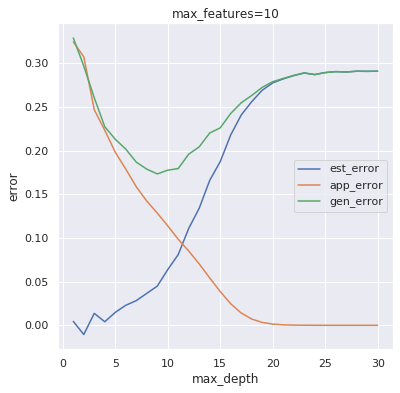

In [22]:
m=max_features[-1]
plt.figure(figsize=(6,6))
sns.lineplot(data=df_est_error,x='max_depth',y=m,label='est_error')
sns.lineplot(data=df_app_error,x='max_depth',y=m,label='app_error')
sns.lineplot(data=df_gen_error,x='max_depth',y=m,label='gen_error')
plt.legend()
plt.ylabel('error')
plt.title('max_features={}'.format(m))
plt.savefig('bias_vs_complexity.png')
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


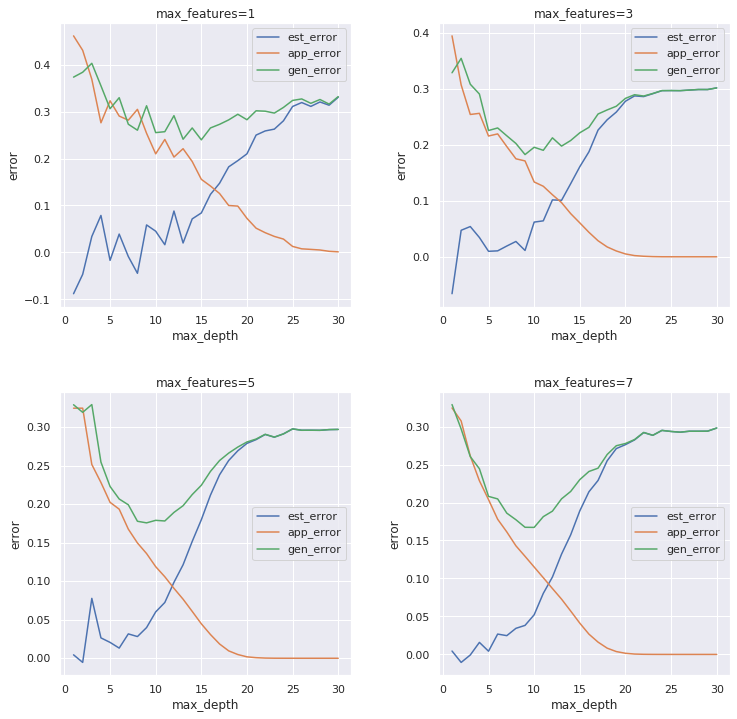

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
plt.subplots_adjust(wspace=0.3,hspace=0.3)
for i,m in enumerate(max_features[:-1]):
    sns.lineplot(data=df_est_error,x='max_depth',y=m,label='est_error',ax=axes[i//2,i%2])
    sns.lineplot(data=df_app_error,x='max_depth',y=m,label='app_error',ax=axes[i//2,i%2])
    sns.lineplot(data=df_gen_error,x='max_depth',y=m,label='gen_error',ax=axes[i//2,i%2])
    plt.legend()
    axes[i//2,i%2].set_ylabel('error')
    axes[i//2,i%2].set_title('max_features={}'.format(m))
plt.savefig('bias_vs_complex_multiple.png')
plt.show()